# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model
## Context
Retinal Optical Coherence Tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

![Figure 1.](https://i.imgur.com/fSTeZMd.png)

Figure 1. Representative Optical Coherence Tomography Images and the Workflow Diagram \[Kermany et. al. 2018\]

(A) (Far left) Choroidal Neo-Vascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic Macular Edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

## Content
* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).
* Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

* Optical coherence tomography (OCT) images (Spectralis OCT, Heidelberg Engineering, Germany) were selected from retrospective cohorts of adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017.

## Acknowledgements
* Data: https://data.mendeley.com/datasets/rscbjbr9sj/2
* Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Installing and Importing Libraries

In [1]:
!pip install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

## Importing Dataset and Data Pre-Processing

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/kermany2018

100% 10.8G/10.8G [01:04<00:00, 238MB/s]
100% 10.8G/10.8G [01:04<00:00, 179MB/s]


In [4]:
! unzip kermany2018.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8050636-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-4.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-805

In [5]:
data_dir = "/content/OCT2017 "
train_data_dir= '/content/OCT2017 /train/'
val_data_dir= '/content/OCT2017 /val/'
test_data_dir= '/content/OCT2017 /test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32

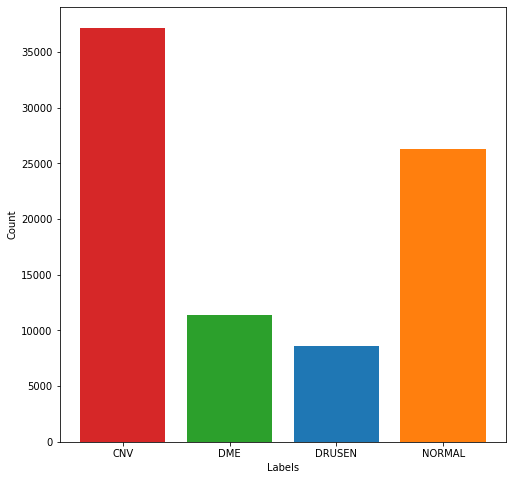

In [6]:
cnv_images = len(glob(train_data_dir + 'CNV/*.jpeg'))
dme_images = len(glob(train_data_dir + 'DME/*.jpeg'))
drusen_images = len(glob(train_data_dir + 'DRUSEN/*.jpeg'))
normal_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Image Histogram (Tonal Distribution)
* Histogram of a normal retina image in the train dataset:

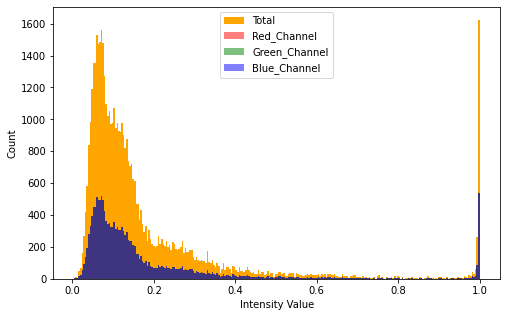

In [7]:
image = mpimg.imread(data_dir + '/train/NORMAL/NORMAL-1001666-1.jpeg')
color_img= gray2rgb(resize(image, (128, 128)))
plt.rcParams['figure.figsize'] = (8.0, 5.0)
_ = plt.hist(color_img.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(color_img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(color_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(color_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.savefig('histogram.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

### Sample Images from the Dataset

In [8]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Normal


<Figure size 720x720 with 0 Axes>

In [9]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/CNV/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


<Figure size 720x720 with 0 Axes>

In [10]:
print("Diabetic Macular Edema (DME)") 
multipleImages = glob(data_dir + 'train/DME/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('dme_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Diabetic Macular Edema (DME)


<Figure size 720x720 with 0 Axes>

In [11]:
print("Drusen")
multipleImages = glob(data_dir + 'train/DRUSEN/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('drusen_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Drusen


<Figure size 720x720 with 0 Axes>

### Keras Data Generators

In [12]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [13]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [14]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

# Model
* VGG16 CNN architecture is used for calssification.
* Pretrained on the 'ImageNet' dataset.

In [15]:
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [16]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

## Baseline Model Training

In [24]:
model.compile(optimizer= keras.optimizers.SGD(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [25]:
numepochs = 5
batch_size = 128
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
callbacks_list = [earlystop,checkpoint]
history = model.fit(train_generator, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        validation_data=valid_generator, 
                        verbose=1,
                        callbacks = callbacks_list)

Epoch 1/5
2609/2609 [==============================] - 941s 360ms/step - loss: 0.4080 - accuracy: 0.8532 - val_loss: 0.3568 - val_accuracy: 0.8750
Epoch 2/5
2609/2609 [==============================] - 874s 335ms/step - loss: 0.4074 - accuracy: 0.8543 - val_loss: 0.3555 - val_accuracy: 0.9062
Epoch 3/5
2609/2609 [==============================] - 869s 333ms/step - loss: 0.4055 - accuracy: 0.8549 - val_loss: 0.3513 - val_accuracy: 0.9062
Epoch 4/5
2609/2609 [==============================] - 862s 331ms/step - loss: 0.4095 - accuracy: 0.8542 - val_loss: 0.3434 - val_accuracy: 0.9062
Epoch 5/5
2609/2609 [==============================] - 830s 318ms/step - loss: 0.4073 - accuracy: 0.8534 - val_loss: 0.3835 - val_accuracy: 0.8125


Evaluations on Test Dataset

In [26]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 3s 107ms/step - loss: 0.3794 - accuracy: 0.8471
Test Loss:  0.37937164306640625
Test Accuracy:  0.8471074104309082


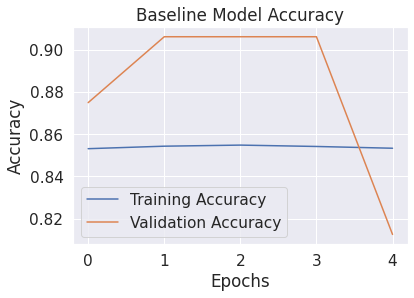

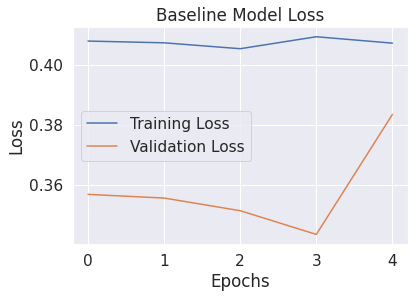

In [27]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

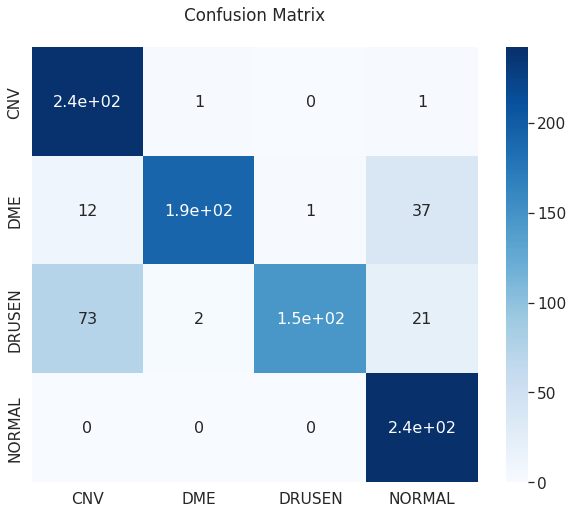

Classification Report

              precision    recall  f1-score   support

         CNV       0.74      0.99      0.85       242
         DME       0.98      0.79      0.88       242
      DRUSEN       0.99      0.60      0.75       242
      NORMAL       0.80      1.00      0.89       242

    accuracy                           0.85       968
   macro avg       0.88      0.85      0.84       968
weighted avg       0.88      0.85      0.84       968



In [28]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Save the model

In [29]:
# save model and architecture to single file
model.save("retinal-oct.h5")
print("Saved model to disk")

Saved model to disk


Prediction test

In [30]:
from PIL import Image
import io
model = tf.keras.models.load_model('retinal-oct.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
from keras.preprocessing import image

test_image = image.load_img("/content/OCT2017 /test/CNV/CNV-1016042-1.jpeg", target_size = (150, 150)) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = np.argmax(model.predict(test_image))
print(result)
print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(result)])

0
CNV
